# Forecasting traffic website with `StatsForecast`

<a class="anchor" id="0.1"></a>
# **Table of Contents** 


1.	[Introduction](#1)
2.	[Case study](#2)
3.	[Loading libraries and data](#3)
4.	[Explore Data with the plot method](#4)
7.	[Split the data into training and testing](#7)
8.	[Implementation with StatsForecast](#8)
9.	[Evaluate the model’s performance](#9)
10.	[Evaluate the model](#10)
11. [Conclusion](#11)
12. [References](#12)

# **Introduction** <a class="anchor" id="1"></a>

[Table of Contents](#0.1)

A time series is a succession of data arranged chronologically, spaced at equal or unequal intervals. The forecasting process consists of predicting the future value of a time series, either by modeling the series based solely on its past behavior (autoregressive) or by using other external variables.

This guide shows an example of how to model different statistical methods such as `HoltWinter` using the `StatsForecast` functions to predict the number of daily visits a web page receives.

`StatsForecast` offers automated solutions that will help us solve the problems, in particular with this guide on website traffic.

We are going to train several models, once those models are trained we are going to perform forecasting with a prediction interval and finally we will perform a 'Crossvalidation' to evaluate each of the trained models, and in this way select the best among all.

# **Case study** <a class="anchor" id="2"></a>

[Table of Contents](#0.1)


The historical data we will use is about web traffic, this is available on the city of Los Angeles website hosted on [Kaggle](https://www.kaggle.com/datasets/cityofLA/lacity.org-website-traffic/data). This data set contains several variables such as the number of user sessions of the city of Los Angeles website for each day from 2014 to 2019. The objective is to generate a forecast model capable of predicting the web traffic that the page will have within 6 days for each type of categories.

In order to robustly evaluate the capacity of each of the models to be used according to the intended use, it is advisable not to limit ourselves to predicting only the last 6 days of the time series, but to simulate the entire process.

Our main objective is to make predictions for the next 6 days on the number of sessions for each of the device categories (table, desktop and mobile).

Let's load the data and take a look:

# **Loading libraries and data** <a class="anchor" id="3"></a>

[Table of Contents](#0.1)

In [1]:
# Handling and processing of Data
# ==============================================================================
import numpy as np
import pandas as pd

import scipy.stats as stats

# StatsForecast
# ==============================================================================
from statsforecast import StatsForecast
from utilsforecast.plotting import plot_series

# Handling time
# ==============================================================================
from calendar import month_abbr

# Hide warnings
# ==============================================================================
from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")

/Users/user/Documents/miniconda3/envs/statsforecast/lib/python3.10/site-packages/statsforecast/core.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# Plot
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946', # #E1F8FF
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

# Define the plot size
# ==============================================================================
from pylab import rcParams
rcParams['figure.figsize'] = (18,7)



## **Load data**

This is a dataset hosted by the city of Los Angeles. The organization has an open data platform found here and they update their information according the amount of data that is brought in. Explore Los Angeles's Data using [Kaggle](https://www.kaggle.com/datasets/cityofLA/lacity.org-website-traffic/data) and all of the data sources available through the city of Los Angeles.

* Update Frequency: This dataset is updated daily.

The fields in our data set are:
* Date: It has year/month/day/T format.
* Device category: type of equipment that has been used for internet browsing.
* Browser: Different type of browser that has been used.
* N.of viewers: number of visitors.
* Sessions: Number of sessions carried out.
* Bounce rate: Bounce rate for each session.

In [3]:
df = pd.read_csv("../tutorial/lacity.org-website-traffic.csv")
df.head()

,Date,Device Category,Browser,# of Visitors,Sessions,Bounce Rate
0,2014-01-01T00:00:00.000,desktop,Chrome,900,934,55.5675
1,2014-01-01T00:00:00.000,desktop,Firefox,692,761,40.8673
2,2014-01-01T00:00:00.000,desktop,Internet Explorer,1038,1107,31.2556
3,2014-01-01T00:00:00.000,desktop,Opera,35,35,100.0000
4,2014-01-01T00:00:00.000,desktop,Safari,484,554,24.9097


We are going to carry out data processing before continuing with our analysis:

1. let's rename the variables.
2. Change data types.
3. Let's add the data for the forecast.
4. We convert the date variables to date format.

In [4]:
df.columns = [k.lower().replace(' ', '_').replace('#', 'qnty') for k in df.columns]
df['date'] = pd.to_datetime(df.date).dt.normalize()
df

,date,device_category,browser,qnty_of_visitors,sessions,bounce_rate
0,2014-01-01,desktop,Chrome,900,934,55.5675
1,2014-01-01,desktop,Firefox,692,761,40.8673
2,2014-01-01,desktop,Internet Explorer,1038,1107,31.2556
3,2014-01-01,desktop,Opera,35,35,100.0000
4,2014-01-01,desktop,Safari,484,554,24.9097
...,...,...,...,...,...,...
8348980,2019-08-27,mobile,Chrome,199,318,50.0000
8348981,2019-08-27,mobile,Firefox,40,40,100.0000
8348982,2019-08-27,mobile,Safari,199,199,79.8995
8348983,2019-08-27,tablet,Amazon Silk,40,40,100.0000


As we can see, our original data has 8,348,985 million observations.

In [5]:
# Aggregate the data based on Date, Device and Session.
data = df[['date', 'device_category', 'sessions']].groupby(['date', 'device_category']).sum().reset_index()

# Fill Missing Any Date to 0
df_pivot = data.pivot(index='device_category', values=['sessions'], columns='date')
df_pivot.fillna(0, inplace=True)

df_pivot = df_pivot.stack().reset_index().sort_values(by=['date', 'device_category']).reset_index(drop=True)
df_pivot.columns = ['device', 'date', 'session']
data = df_pivot[['date', 'device', 'session']]

del df_pivot

Our final data is as follows

In [6]:
data

,date,device,session
0,2014-01-01,desktop,1032805.0
1,2014-01-01,mobile,537573.0
2,2014-01-01,tablet,92474.0
3,2014-01-02,desktop,2359710.0
4,2014-01-02,mobile,607544.0
...,...,...,...
6190,2019-08-26,mobile,4893.0
6191,2019-08-26,tablet,199.0
6192,2019-08-27,desktop,438.0
6193,2019-08-27,mobile,557.0


The input to StatsForecast is always a data frame in long format with three columns: unique_id, ds and y:

* The `unique_id` (string, int or category) represents an identifier for the series.

* The `ds` (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast.

In [7]:
data=data.rename(columns={"date": "ds","device":"unique_id", "session": "y"})
data.head()

,ds,unique_id,y
0,2014-01-01,desktop,1032805.0
1,2014-01-01,mobile,537573.0
2,2014-01-01,tablet,92474.0
3,2014-01-02,desktop,2359710.0
4,2014-01-02,mobile,607544.0


The original data has more detailed information about the sessions, such as the browser and the number of visitors, but we don't need it for this tutorial.

We then grouped the data by date and device category and added the number of sessions for each group.

Here we have 3 time series: one for desktop, one for mobile and one for tablet.

They are stacked long format, meaning that each row represents a single observation.

We are going to make a filter to see that if we have values with zero, we are interested in knowing the number of sessions that have been started, we will replace the zeros with `NA` and then we will fill them with the `ffill` method.

In [8]:
data[data["y"] == 0]

,ds,unique_id,y
3197,2016-12-01,tablet,0.0
5240,2018-10-13,tablet,0.0


In [9]:
data['y'] = data['y'].replace(0.0, pd.NA)
data['y'] = data['y'].fillna(method='ffill')

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6195 entries, 0 to 6194
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         6195 non-null   datetime64[ns]
 1   unique_id  6195 non-null   object        
 2   y          6195 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 145.3+ KB


# **Explore Data with the plot method** <a class="anchor" id="4"></a>

[Table of Contents](#0.1)

When you want to generate a forecasting model, it is important to represent the time series values. This allows patterns such as trends and seasonality to be identified.

We will use the `plot` method of `Statsforecast` to visualize our data. This method prints 8 random series from the dataset and is useful for basic EDA.

This is what our data looks like, after having performed a couple of maneuvers on our data.

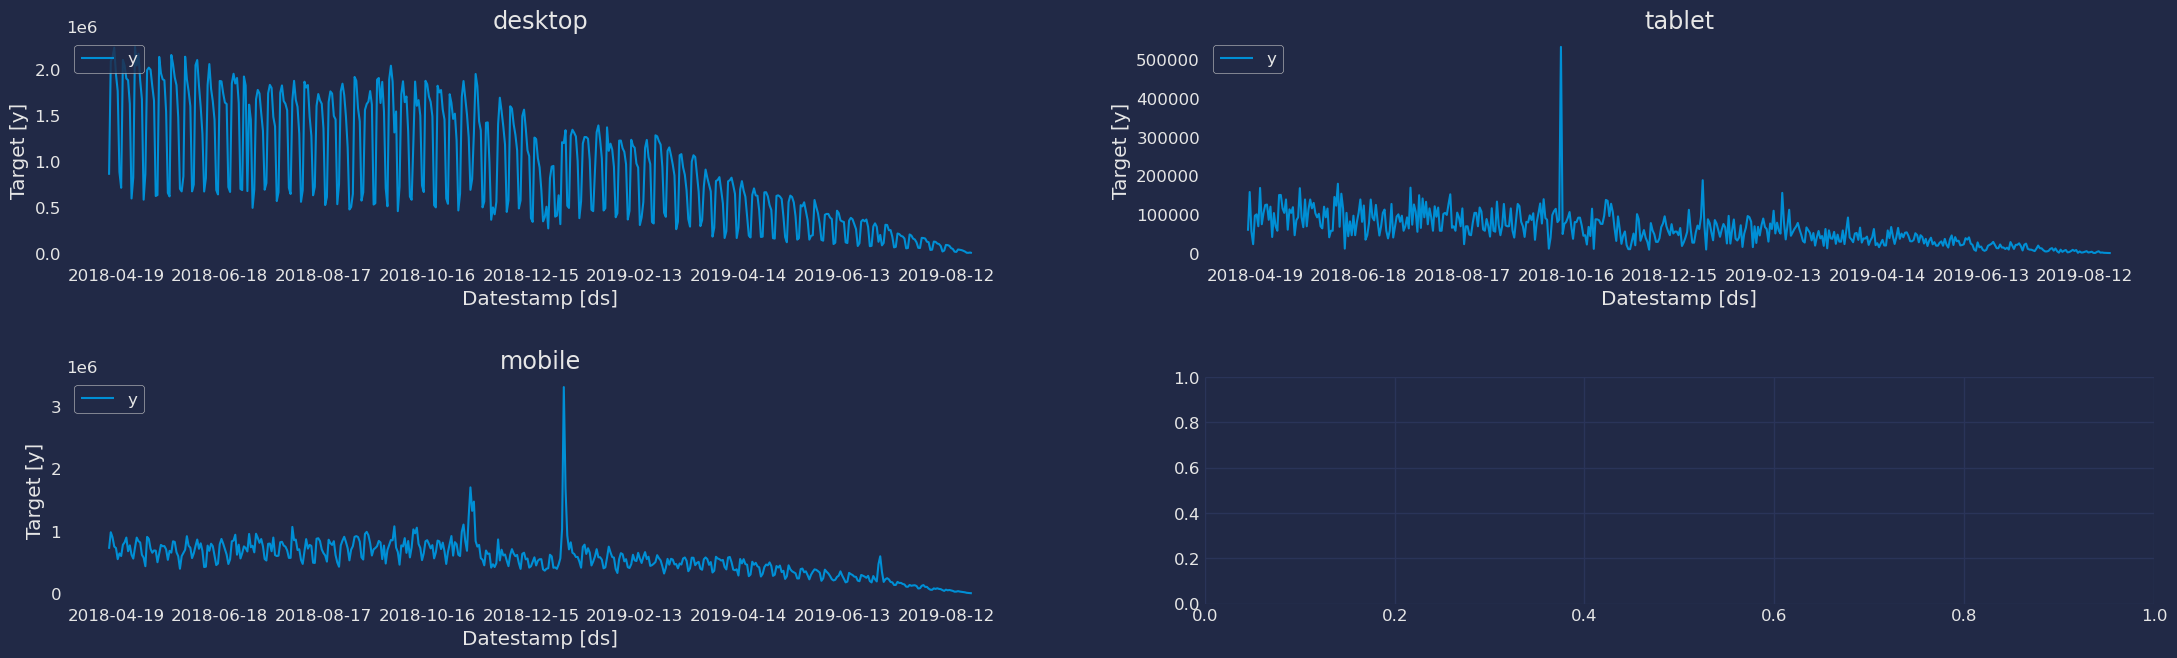

In [11]:
StatsForecast.plot(data, engine="matplotlib", max_insample_length=500)

In the previous graph we can observe the behavior of each of the categories of devices in our time series over time, that is, the number of sessions has been decreasing over time.

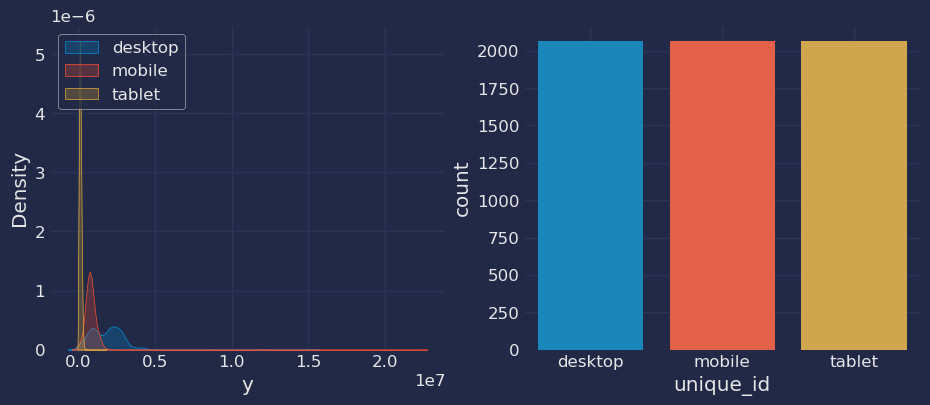

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
for device_type in data['unique_id'].unique():
    sns.kdeplot(data.loc[data['unique_id'] == device_type, "y"], shade=True, ax=ax[0], label=device_type)    
    ax[0].legend(loc='upper left')
    ax[0].grid(2)

sns.countplot(x=data['unique_id'])
ax[1].grid(2);

### **Seasonal Time Plots**

We are going to analyze the stationarity for the number of sessions in a general way, and thus determine or visualize at what time in the period of our data there is more stationarity in the traffic of website users.

Recall that stationarity refers to the characteristic of a time series in which statistical properties, such as the mean and variance, are constant over time. This implies that the properties of the time series do not depend on the specific time at which the data are observed.

In [13]:
df1=data.copy()
df1['day'] = df1['ds'].dt.day
df1['week'] = df1['ds'].dt.isocalendar()['week']
df1['month'] = df1['ds'].dt.month
df1['quarter'] = df1['ds'].dt.quarter
df1['year'] = df1['ds'].dt.year

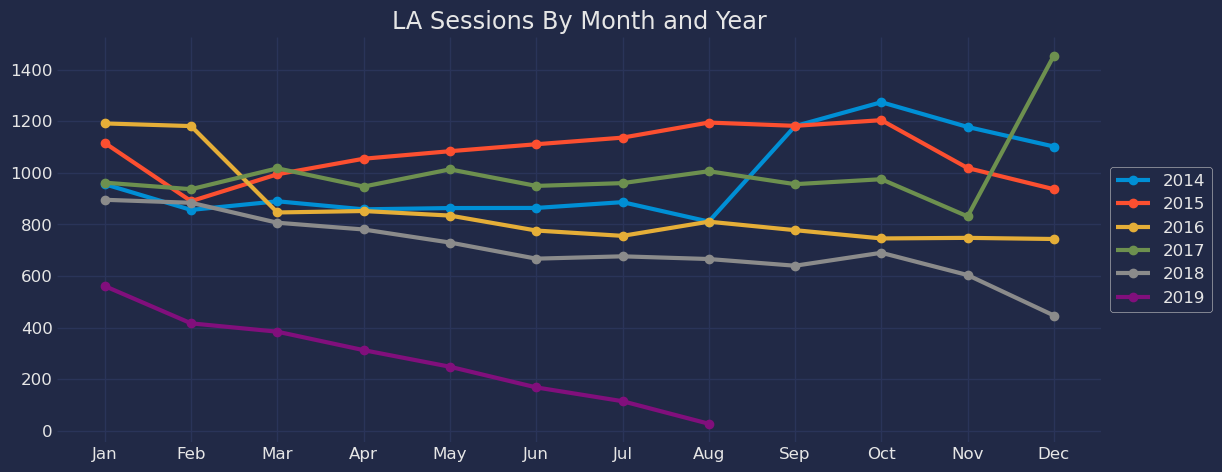

In [14]:
aux_plot = df1[['y', 'month', 'year']].groupby(['year', 'month']).sum('y').reset_index()
aux_plot.sort_values(by=['year', 'month'], inplace=True)
aux_plot['y'] = aux_plot['y'] / 1e5

fig, ax = plt.subplots(figsize=(12,5))
plt.xticks(
    ticks=range(1, len(aux_plot.month.unique()) + 1), 
    labels=[month_abbr[k] for k in set(aux_plot.month.unique())]
);

for year in aux_plot['year'].unique():
    aux = aux_plot[aux_plot['year'] == year]
    ax.plot(aux['month'], aux['y'], label=year, linewidth=3, marker='o')

ax.set_title('LA Sessions By Month and Year')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(2)

We can see in the graph that certain seasonalities occur in some months and years, this gives us a guideline to know how web traffic is behaving in each period being analyzed.

## **Autocorrelation plots**

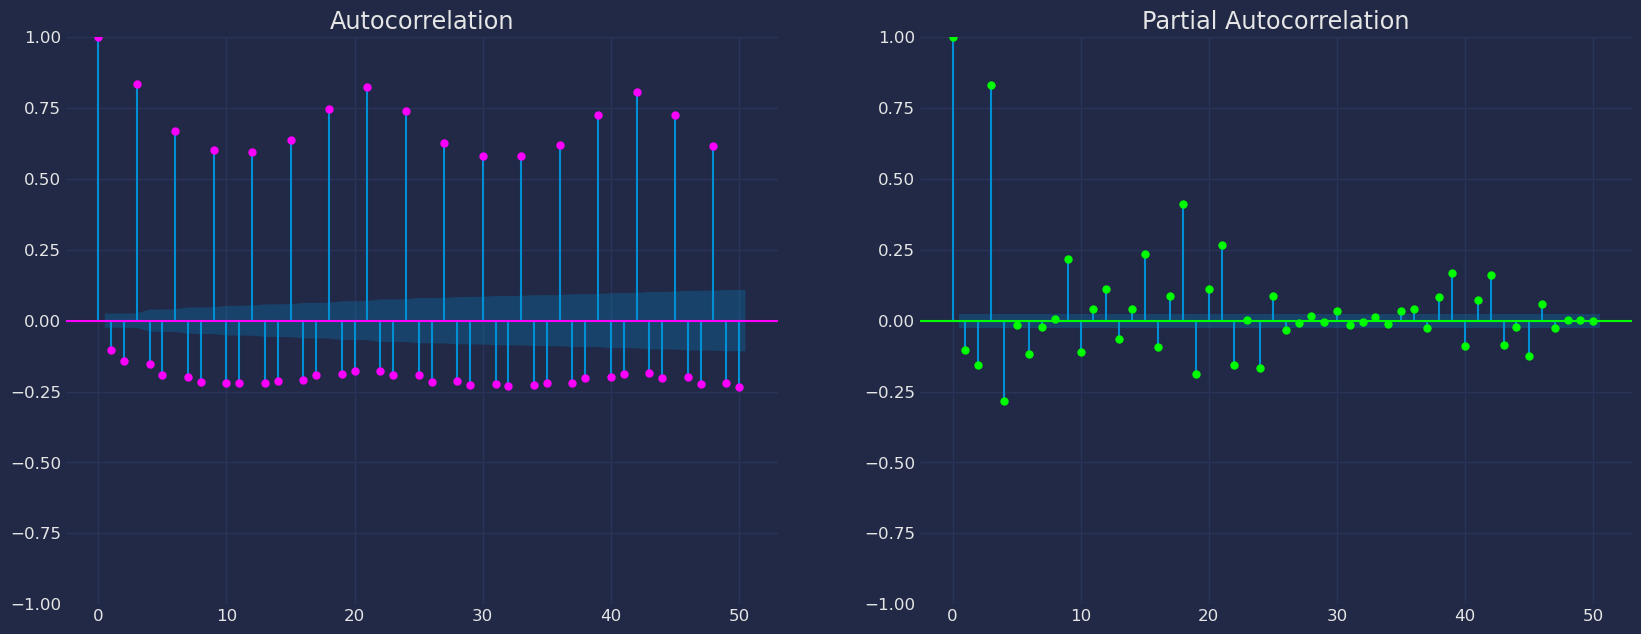

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(data["y"],  lags=50, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

# Grafico
plot_pacf(data["y"],  lags=50, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

#plt.savefig("Gráfico de Densidad y qq")
plt.show();

The autocorrelation and partial autocorrelation graphs show a clear association between the number of users on one day and the previous days. This type of correlation is an indication that autoregressive models can work well.

## **Decomposition of the time series**

How to decompose a time series and why?

In time series analysis to forecast new values, it is very important to know past data. More formally, we can say that it is very important to know the patterns that values follow over time. There can be many reasons that cause our forecast values to fall in the wrong direction. Basically, a time series consists of four components. The variation of those components causes the change in the pattern of the time series. These components are:

* **Level:** This is the primary value that averages over time.
* **Trend:** The trend is the value that causes increasing or decreasing patterns in a time series.
* **Seasonality:** This is a cyclical event that occurs in a time series for a short time and causes short-term increasing or decreasing patterns in a time series.
* **Residual/Noise:** These are the random variations in the time series.

Combining these components over time leads to the formation of a time series. Most time series consist of level and noise/residual and trend or seasonality are optional values.

If seasonality and trend are part of the time series, then there will be effects on the forecast value. As the pattern of the forecasted time series may be different from the previous time series.

The combination of the components in time series can be of two types:
* Additive
* multiplicative


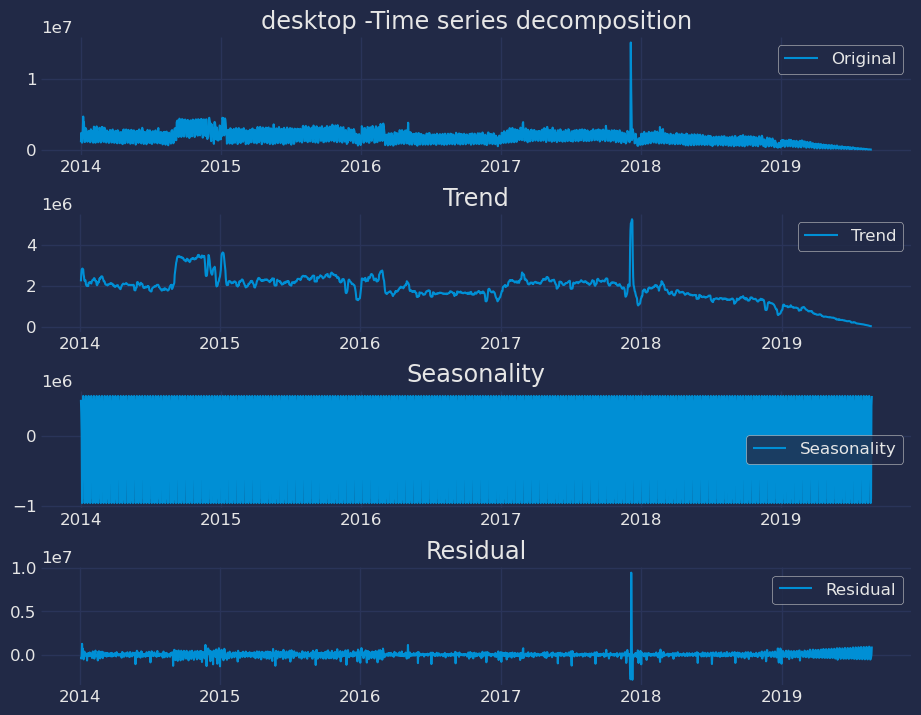

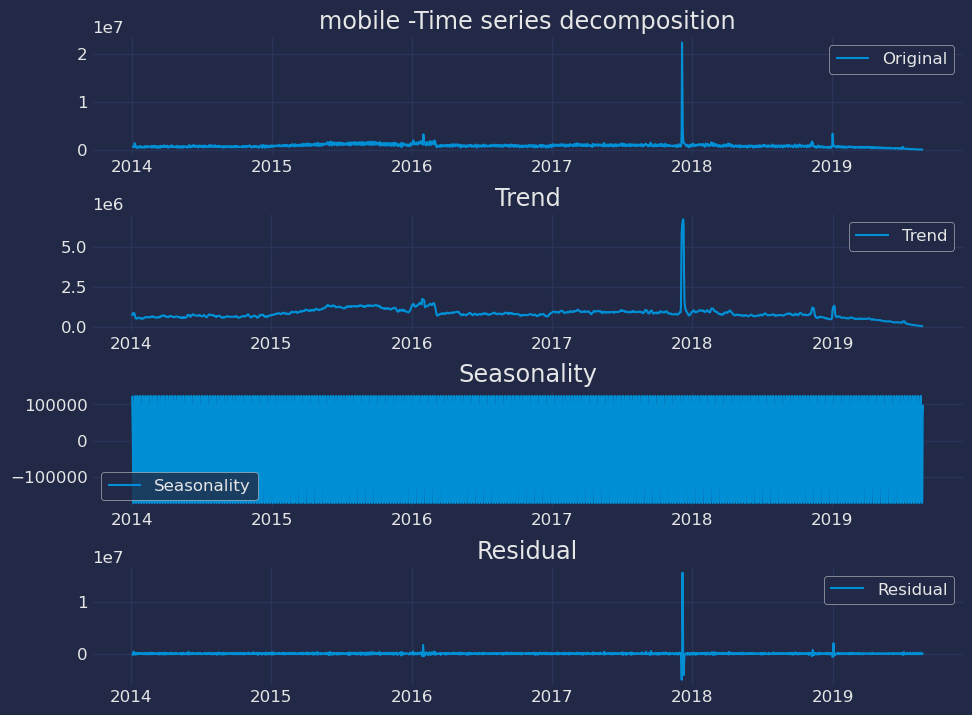

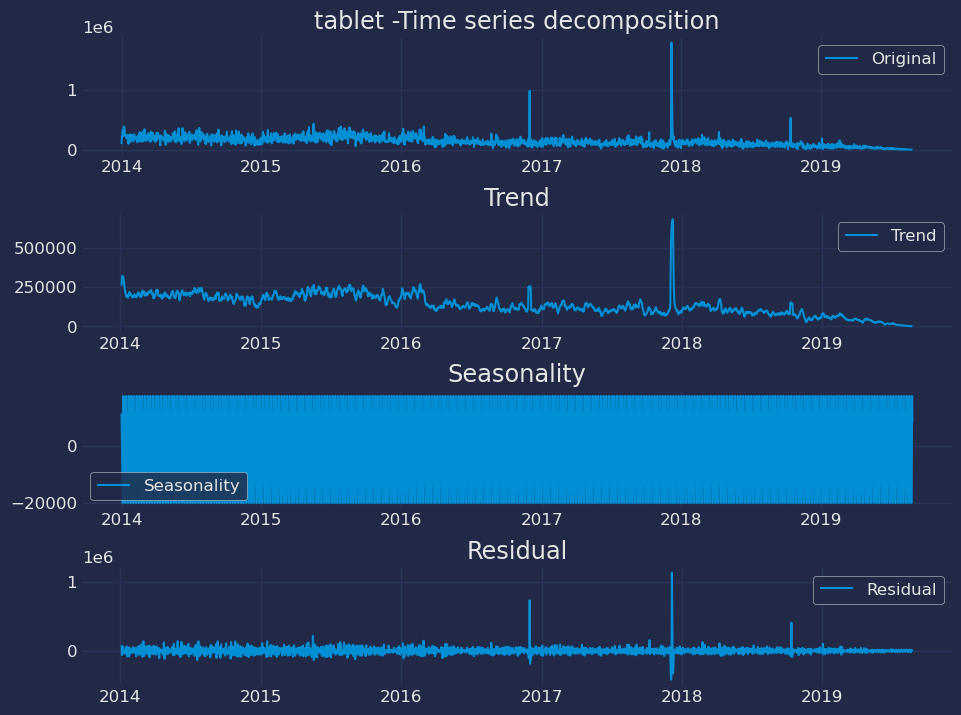

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose 
unique_ids = data['unique_id'].unique()

for unique_id in unique_ids:
    subset = data[data['unique_id'] == unique_id]
    subset = subset.set_index('ds')
    
    decomposition = seasonal_decompose(subset['y'], model='additive')
    
    fig, axes = plt.subplots(4, 1, figsize=(10, 8))
    plt.subplots_adjust(hspace=0.5)
    
    axes[0].plot(subset['y'], label='Original')
    axes[0].set_title(f'{unique_id} -Time series decomposition')
    axes[0].legend()
    
    axes[1].plot(decomposition.trend, label='Trend')
    axes[1].set_title('Trend')
    axes[1].legend()
    
    axes[2].plot(decomposition.seasonal, label='Seasonality')
    axes[2].set_title('Seasonality')
    axes[2].legend()
    
    axes[3].plot(decomposition.resid, label='Residual')
    axes[3].set_title('Residual')
    axes[3].legend()
    
    plt.show()

# **Split the data into training and testing** <a class="anchor" id="7"></a>

[Table of Contents](#0.1)

Let's divide our data into sets
1. Data to train our model
2. Data to test our model

For the test data we will use the last 6 days to test and evaluate the performance of our model.

In [18]:
train = data[data.ds<='2019-08-25'] 
test = data[data.ds>'2019-08-25'] 

print("Data size")

train.shape, test.shape

Data size


((6189, 3), (6, 3))

# **Implementation with StatsForecast** <a class="anchor" id="8"></a>

[Table of Contents](#0.1)

We are going to create and train different models. By training different models it will help us make a better decision about which model is the best, and therefore it will help us have better predictions about the number of sessions initiated in LA web traffic.

## **Load libraries**

In [19]:
from statsforecast import StatsForecast
from statsforecast.models import HoltWinters, SeasonalNaive

## **Building Model**
Import and instantiate the models. Setting the argument is sometimes tricky. This article on [Seasonal periods](https://robjhyndman.com/hyndsight/seasonal-periods/)) by the master, Rob Hyndmann, can be useful `season_length`.

To learn more about the models and parameters you can review [here](https://nixtla.github.io/statsforecast/src/core/models.html#autoarima),
and to learn more about theory and uses you can check [here](https://nixtla.github.io/statsforecast/docs/models/autoarima.html).

In [34]:
season_length = 7 # Dayly data 
horizon = len(test) # number of predictions

# We call the model that we are going to use
models = [
    HoltWinters(season_length=7, error_type='A', alias='hws_add'),
    HoltWinters(season_length=7, error_type='M', alias='hws_mul'),
    SeasonalNaive(season_length=7)
]

We fit the models by instantiating a new StatsForecast object with the following parameters:

models: a list of models. Select the models you want from models and import them.

* `freq:` a string indicating the frequency of the data. (See panda’s available frequencies.)

* `n_jobs:` n_jobs: int, number of jobs used in the parallel processing, use -1 for all cores.

* `fallback_model:` a model to be used if a model fails.

Any settings are passed into the constructor. Then you call its fit method and pass in the historical data frame.

In [35]:
# Instantiate StatsForecast class as sf
sf = StatsForecast(models=models, freq='D', n_jobs=-1, fallback_model = SeasonalNaive(season_length=7))

## **Fit the Model**

In [36]:
# fit the models
sf.fit(train)

StatsForecast(models=[hws_add,hws_mul,SeasonalNaive])

## **Forecast Method**

If you want to gain speed in productive settings where you have multiple series or models we recommend using the `StatsForecast.forecast` method instead of `.fit` and `.predict`.

The main difference is that the `.forecast` doest not store the fitted values and is highly scalable in distributed environments.

The forecast method takes two arguments: forecasts next `h` (horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case, 6 days ahead.

* `level (list of floats):` this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval. For example, `level=[90]` means that the model expects the real value to be inside that interval 90% of the times.


In [37]:
%%time
# Forecasting
forecast_df = sf.forecast(horizon, fitted=True,level=[90])

forecast_df.head()

CPU times: user 6.12 ms, sys: 20.9 ms, total: 27 ms
Wall time: 10.6 s


,ds,hws_add,hws_add-lo-90,hws_add-hi-90,hws_mul,hws_mul-lo-90,hws_mul-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90
unique_id,,,,,,,,,,
desktop,2019-08-26,157411.703125,-547045.5000,861868.875,6232.896484,4254.565918,8211.227539,39548.0,-948964.8125,1.028061e+06
desktop,2019-08-27,251258.671875,-510388.0000,1012905.375,1928.349121,-171.659958,4028.358154,36140.0,-952372.8125,1.024653e+06
desktop,2019-08-28,287374.062500,-527495.9375,1102244.125,-2754.082275,-4894.401855,-613.762634,32929.0,-955583.8125,1.021442e+06
desktop,2019-08-29,280948.718750,-583904.1250,1145801.625,-6505.433105,-8761.333008,-4249.533203,25827.0,-962685.8125,1.014340e+06
desktop,2019-08-30,233285.109375,-678837.8750,1145408.125,-9110.290039,-12013.065430,-6207.514648,17045.0,-971467.8125,1.005558e+06


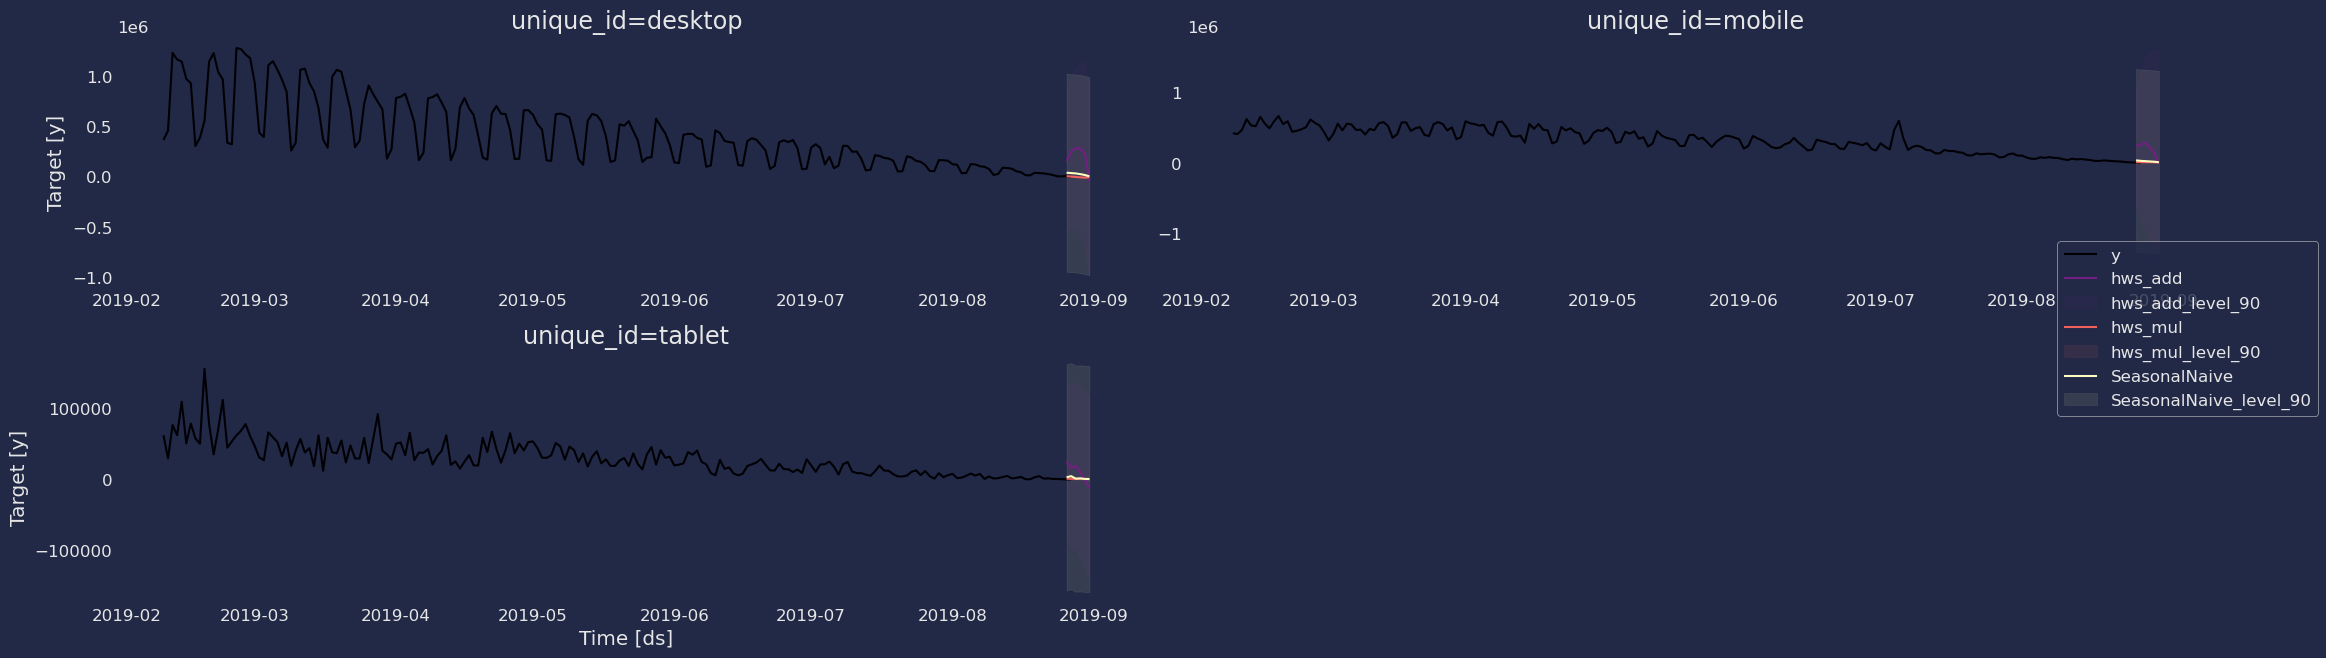

In [38]:
#sf.plot(data, forecast_df.reset_index(),  max_insample_length=200, )
plot_series(data, forecast_df.reset_index(),level=[90],  max_insample_length=200, palette="magma")

# **Evaluate the model’s performance** <a class="anchor" id="9"></a>

[Table of Contents](#0.1)

In previous steps, we’ve taken our historical data to predict the future. However, to asses its accuracy we would also like to know how the model would have performed in the past. To assess the accuracy and robustness of your models on your data perform Cross-Validation.

With time series data, Cross Validation is done by defining a sliding window across the historical data and predicting the period following it. This form of cross-validation allows us to arrive at a better estimation of our model’s predictive abilities across a wider range of temporal instances while also keeping the data in the training set contiguous as is required by our models.

The following graph depicts such a Cross Validation Strategy:

![](https://raw.githubusercontent.com/Nixtla/statsforecast/main/nbs/imgs/ChainedWindows.gif)

## **Perform time series cross-validation**

Cross-validation of time series models is considered a best practice but most implementations are very slow. The statsforecast library implements cross-validation as a distributed operation, making the process less time-consuming to perform. If you have big datasets you can also perform Cross Validation in a distributed cluster using Ray, Dask or Spark.

In this case, we want to evaluate the performance of each model for the last 6 days `(n_windows=5)`, forecasting every days `(step_size=12)`. Depending on your computer, this step should take around 1 min.

The `cross_validation` method from the `StatsForecast` class takes the following arguments.

* `df:` training data frame

* `h (int):` represents h steps into the future that are being forecasted. In this case, 6 days ahead.

* `step_size (int):` step size between each window. In other words: how often do you want to run the forecasting processes.

* `n_windows(int):` number of windows used for cross validation. In other words: what number of forecasting processes in the past do you want to evaluate.

In [39]:
crossvalidation_df = sf.cross_validation(df=train,
                                         h=horizon,
                                         step_size=12,
                                         n_windows=5)

The crossvaldation_df object is a new data frame that includes the following columns:

*  `unique_id:` index. If you dont like working with index just run crossvalidation_df.resetindex()
* `ds:` datestamp or temporal index
* `cutoff:` the last datestamp or temporal index for the `n_windows`.
* `y:` true value
* `"model":` columns with the model’s name and fitted value.

In [40]:
crossvalidation_df

,ds,cutoff,y,hws_add,hws_mul,SeasonalNaive
unique_id,,,,,,
desktop,2019-07-03,2019-07-02,287023.0,460453.531250,298132.187500,345946.0
desktop,2019-07-04,2019-07-02,123254.0,424642.312500,254426.000000,366730.0
desktop,2019-07-05,2019-07-02,198778.0,324991.531250,214671.328125,284594.0
desktop,2019-07-06,2019-07-02,84573.0,-115291.929688,98829.398438,75523.0
desktop,2019-07-07,2019-07-02,110533.0,-176146.187500,104281.453125,79546.0
...,...,...,...,...,...,...
tablet,2019-08-21,2019-08-19,1194.0,13930.548828,2242.922607,1560.0
tablet,2019-08-22,2019-08-19,1627.0,5261.972168,2088.020508,2377.0
tablet,2019-08-23,2019-08-19,797.0,-6937.168457,1831.407227,3618.0


Next, we will evaluate the performance of every model for every series using common error metrics like Mean Absolute Error (MAE) or Mean Square Error (MSE) Define a utility function to evaluate different error metrics for the cross validation data frame.

First import the desired error metrics from `mlforecast.losses`. Then define a utility function that takes a `cross-validation` data frame as a metric and returns an evaluation data frame with the average of the error metric for every `unique_id` and fitted model and all `cutoffs`.

In [41]:
from utilsforecast.losses import mse, rmse
from utilsforecast.evaluation import evaluate

In [42]:
def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    # Calculate loss for every unique_id and cutoff.    
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id').mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals

We are going to create the data frame with the results of evaluating your cross-validation data frame using an rmse metric or whatever metric you want to use.

In [43]:
evaluation_df = evaluate_cross_validation(crossvalidation_df.reset_index(), rmse)
evaluation_df

,hws_add,hws_mul,SeasonalNaive,best_model
unique_id,,,,
desktop,206964.453125,20501.156250,52369.093750,hws_mul
mobile,162453.625000,54623.226562,57133.695312,hws_mul
tablet,12759.750977,4389.774414,5298.583984,hws_mul


From the models that we have trained, we have obtained the best models for each category of equipment, in this way we can make our forecasts for website traffic with the best models found.

### **Select the best model for each unique series**

Let's define a utility function that takes your forecast data frame with the predictions and the evaluation data frame and returns a data frame with the best possible forecast for each unique ID.

In [44]:
def get_best_model_forecast(forecasts_df, evaluation_df):
    df = forecasts_df.set_index('ds', append=True).stack().to_frame().reset_index(level=2) # Wide to long 
    df.columns = ['model', 'best_model_forecast'] 
    df = df.join(evaluation_df[['best_model']])
    df = df.query('model.str.replace("-lo-90|-hi-90", "", regex=True) == best_model').copy()
    df.loc[:, 'model'] = [model.replace(bm, 'best_model') for model, bm in zip(df['model'], df['best_model'])]
    df = df.drop(columns='best_model').set_index('model', append=True).unstack()
    df.columns = df.columns.droplevel()
    df = df.reset_index(level=1)
    return df

In [45]:
prod_forecasts_df = get_best_model_forecast(forecast_df, evaluation_df)

prod_forecasts_df.head(10)

model,ds,best_model,best_model-hi-90,best_model-lo-90
unique_id,,,,
desktop,2019-08-26,6232.896484,8211.227539,4254.565918
desktop,2019-08-27,1928.349121,4028.358154,-171.659958
desktop,2019-08-28,-2754.082275,-613.762634,-4894.401855
desktop,2019-08-29,-6505.433105,-4249.533203,-8761.333008
desktop,2019-08-30,-9110.290039,-6207.514648,-12013.065430
desktop,2019-08-31,-5881.084473,-2611.567139,-9150.601562
mobile,2019-08-26,8595.041016,11935.627930,5254.453125
mobile,2019-08-27,9294.462891,12652.499023,5936.427246
mobile,2019-08-28,9991.215820,13361.273438,6621.158203


In [46]:
sf.plot(data, prod_forecasts_df, engine='plotly',max_insample_length=100)

# **Conclusion**

Based on the results provided, we can conclude that the most effective model for forecasting website traffic is the `hws_mul` (Multiplicative Holt-Winters) model. This model has demonstrated superior performance compared to the `hws_add` (Holt-Winters additive) and `SeasonalNaive` models for all three device categories: desktop, mobile, and tablet.

The model that achieves the best results for each of the equipment categories is:

- For the desktop computer it is the `multiplicative HoltWinter` model.
- for the mobile team is the `multiplicative HoltWinter` model.
- For the table team it is the `multiplicative HoltWinter` model.


In [47]:
evaluation_df

,hws_add,hws_mul,SeasonalNaive,best_model
unique_id,,,,
desktop,206964.453125,20501.156250,52369.093750,hws_mul
mobile,162453.625000,54623.226562,57133.695312,hws_mul
tablet,12759.750977,4389.774414,5298.583984,hws_mul


These results indicate that the `hws_mul` model is able to more accurately capture and predict seasonal trends and patterns in website traffic. Therefore, it is recommended to use this model to make future website traffic forecasts, as it has proven to be the most appropriate based on the data and results provided.

Possible model improvements for future website traffic predictions:

* Include other models.
* Consider some exogenous variables.
* Use Machine learning models.

# **References** <a class="anchor" id="11"></a>


[Table of Contents](#0.1)



1. [Nixtla-Arima](https://nixtla.github.io/statsforecast/src/core/models.html#arima-family)

2. [Rob J. Hyndman and George Athanasopoulos (2018). “Forecasting principles and practice, Time series cross-validation”.](https://otexts.com/fpp3/tscv.html)
